In [71]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-question-pairs/train.csv.zip
/kaggle/input/quora-question-pairs/sample_submission.csv.zip
/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/test.csv.zip


In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

> # Load Dataset 

In [73]:
df = pd.read_csv('/kaggle/input/quora-question-pairs/train.csv.zip', compression='zip')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [75]:
df.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614502,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [76]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404287 non-null  int64 
 1   qid1          404287 non-null  int64 
 2   qid2          404287 non-null  int64 
 3   question1     404287 non-null  object
 4   question2     404287 non-null  object
 5   is_duplicate  404287 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


In [77]:
df.is_duplicate.value_counts()

is_duplicate
0    255024
1    149263
Name: count, dtype: int64

<Axes: ylabel='count'>

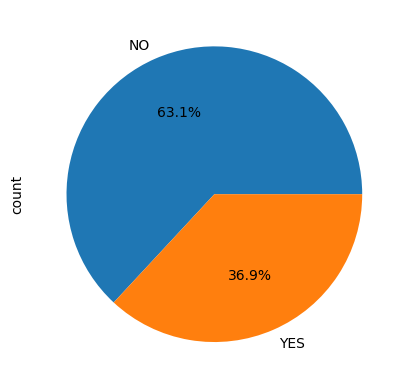

In [78]:
df.is_duplicate.value_counts().plot(kind='pie', labels=['NO', 'YES'], autopct='%1.1f%%')

> # Data Preprocessing

In [79]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

In [80]:
data = df[:10]
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [81]:
data.shape

(10, 6)

In [82]:
data['question1'] = data['question1'].fillna('').apply(clean_text)
data['question2'] = data['question2'].fillna('').apply(clean_text)

<ipython-input-82-3ea8cdb15937>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['question1'] = data['question1'].fillna('').apply(clean_text)
<ipython-input-82-3ea8cdb15937>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['question2'] = data['question2'].fillna('').apply(clean_text)


In [83]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,step step guide invest share market india,step step guide invest share market,0
1,1,3,4,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,0
2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0
3,3,7,8,mentally lonely solve,find remainder math 23 24 math divided 24 23,0
4,4,9,10,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0


In [84]:
data.question2.values[1]

'would happen indian government stole kohinoor koh noor diamond back'

In [85]:
df.question2.values[1]

'What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?'

In [86]:
cleaned_file = '/kaggle/working/cleaned_quora_data.csv'
if os.path.exists(cleaned_file):
    df = pd.read_csv(cleaned_file)
    print("Loaded cleaned data from file.")
else:
    df['question1'] = df['question1'].fillna('').apply(clean_text)
    df['question2'] = df['question2'].fillna('').apply(clean_text)

    # Save cleaned data for future use
    df.to_csv(cleaned_file, index=False)
    print("Cleaned data saved for future use.")

Loaded cleaned data from file.


In [87]:
df.question2.values[1]

'would happen indian government stole kohinoor koh noor diamond back'

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404287 entries, 0 to 404286
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404287 non-null  int64 
 1   qid1          404287 non-null  int64 
 2   qid2          404287 non-null  int64 
 3   question1     404200 non-null  object
 4   question2     404212 non-null  object
 5   is_duplicate  404287 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [89]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404146 entries, 0 to 404286
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404146 non-null  int64 
 1   qid1          404146 non-null  int64 
 2   qid2          404146 non-null  int64 
 3   question1     404146 non-null  object
 4   question2     404146 non-null  object
 5   is_duplicate  404146 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


In [90]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,step step guide invest share market india,step step guide invest share market,0
1,1,3,4,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,0
2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0
3,3,7,8,mentally lonely solve,find remainder math 23 24 math divided 24 23,0
4,4,9,10,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0


In [91]:
df = df.sample(frac=0.4, random_state=42).reset_index(drop=True)  # Use only 40% of the dataset

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161658 entries, 0 to 161657
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            161658 non-null  int64 
 1   qid1          161658 non-null  int64 
 2   qid2          161658 non-null  int64 
 3   question1     161658 non-null  object
 4   question2     161658 non-null  object
 5   is_duplicate  161658 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 7.4+ MB


In [93]:
df.is_duplicate.value_counts()

is_duplicate
0    101942
1     59716
Name: count, dtype: int64

> # Feature Engineering

In [94]:
df['q1_word_count'] = df['question1'].apply(lambda x: len(x.split()))
df['q2_word_count'] = df['question2'].apply(lambda x: len(x.split()))
df['common_word_count'] = df.apply(lambda x: len(set(x['question1'].split()) & set(x['question2'].split())), axis=1)
df['word_share'] = df['common_word_count'] / (df['q1_word_count'] + df['q2_word_count'] + 1e-6)

In [95]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_word_count', 'q2_word_count', 'common_word_count', 'word_share'],
      dtype='object')

In [96]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_word_count,q2_word_count,common_word_count,word_share
0,56406,99274,99275,girls never fall nice guys,girls fall nice guy,1,5,4,3,0.333333
1,383166,515094,515095,self description feel like,feel like completely self confident daily life,0,4,7,3,0.272727
2,3941,7806,7807,best gaming laptop 40k,best gaming laptop 40 000 rs,1,4,6,3,0.300000
3,393899,526738,526739,authoritative dictionary samsung engineers use...,account business losses without losing busines...,0,9,7,0,0.000000
4,296578,78228,147490,think world war iii would play,would world war iii play,1,6,5,5,0.454545


In [97]:
tfidf = TfidfVectorizer(max_features=5000)
q1_tfidf = tfidf.fit_transform(df['question1'])
q2_tfidf = tfidf.transform(df['question2'])

In [98]:
X = hstack((q1_tfidf, q2_tfidf, df[['q1_word_count', 'q2_word_count', 'common_word_count', 'word_share']].values))
y = df['is_duplicate'].values

> # Visualizations

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


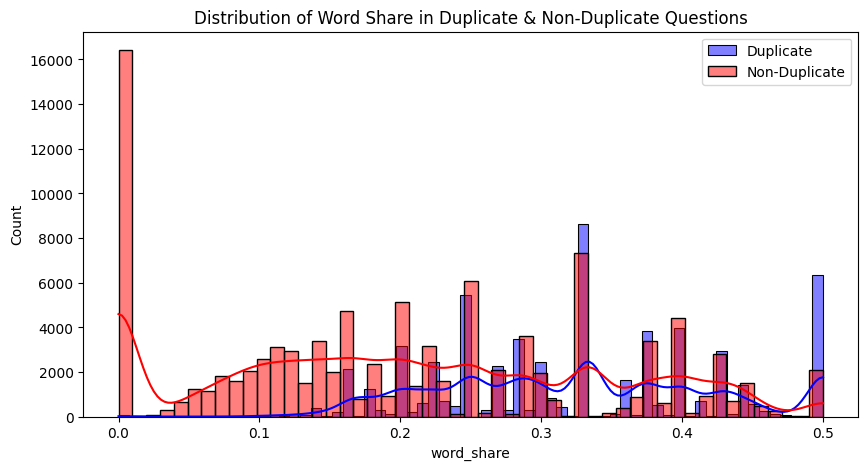

In [99]:
plt.figure(figsize=(10,5))
sns.histplot(df['word_share'][df['is_duplicate'] == 1], color='blue', kde=True, label='Duplicate')
sns.histplot(df['word_share'][df['is_duplicate'] == 0], color='red', kde=True, label='Non-Duplicate')
plt.legend()
plt.title("Distribution of Word Share in Duplicate & Non-Duplicate Questions")
plt.show()

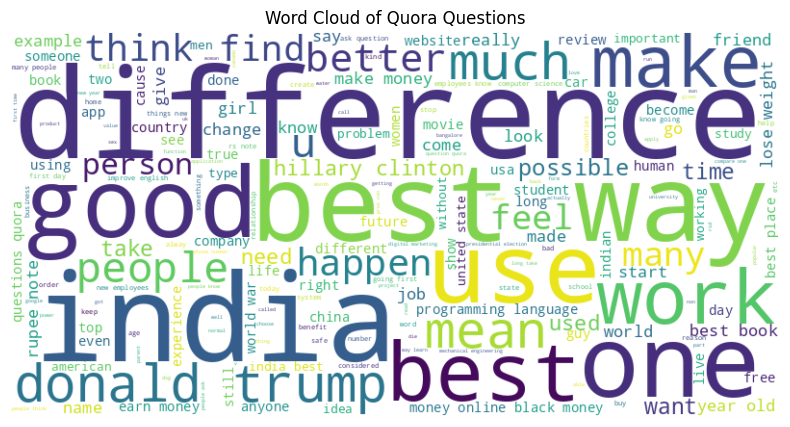

In [100]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df['question1'] + " " + df['question2']))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Quora Questions")
plt.show()

> # Split Data

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

> # Train Models

In [102]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')
}

In [103]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.7673
              precision    recall  f1-score   support

           0       0.80      0.84      0.82     20411
           1       0.70      0.64      0.67     11921

    accuracy                           0.77     32332
   macro avg       0.75      0.74      0.75     32332
weighted avg       0.76      0.77      0.77     32332

Random Forest Accuracy: 0.8013
              precision    recall  f1-score   support

           0       0.82      0.88      0.85     20411
           1       0.76      0.68      0.71     11921

    accuracy                           0.80     32332
   macro avg       0.79      0.78      0.78     32332
weighted avg       0.80      0.80      0.80     32332

XGBoost Accuracy: 0.7729
              precision    recall  f1-score   support

           0       0.79      0.87      0.83     20411
           1       0.73      0.61      0.66     11921

    accuracy                           0.77     32332
   macro avg       0.76      0.74  

> # Compare Models

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


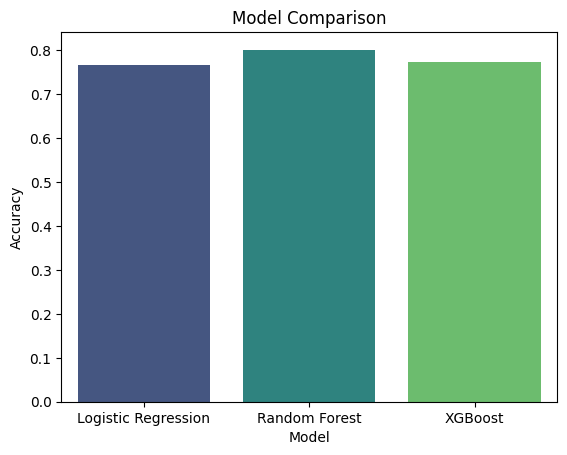

In [104]:
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.show()

> # Best Model Selection

In [105]:
best_model = max(results, key=results.get)
print(f"Best Model: {best_model} with Accuracy: {results[best_model]:.4f}")

Best Model: Random Forest with Accuracy: 0.8013
